In [2]:
import numpy as np 
import sys
import os
import re
def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning' # /root/autodl-tmp/fnirs-treatment-response-prediction
    else:
        print("Current system is neither macOS nor Ubuntu")
    os.chdir(main_fold_path)
    
set_path()    


import pandas as pd 
def get_best_acc_epoch(csv_file):
    df = pd.read_csv(csv_file)
    index_of_best_acc = df['val_accuracy'].argmax()
    return index_of_best_acc

import glob 

def delete_files_starting_with(directory, prefix):
    pattern = os.path.join(directory, '*' + prefix + '*') 
    files_to_delete = glob.glob(pattern)
    for file in files_to_delete:
        try: 
            os.remove(file)
        except Exception as e:
            print(e)
        
seeds=[1720351610, 1720353641, 1720355734, 1720358054, 1720360139]

dataset = 'diagnosis514'
model_config_dict = {
    # 'jamba_multimodal':[ f'eval{i}mdd_classification_jamba' for i in range(2)],
    # 'cnn_transformer': [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)],
    # 'mamba': [f'eval_{i}mdd_classification_mamba_subject_all_hb_simple_all_1d_SPECIFY_FOLD_2_nor' for i in range(1, 11)],
    # 'jamba_hybrid': [f'eval_{i}mdd_classification_mamba_subject_all_seq_ch_hb_data_1d_SPECIFY_FOLD_5_nor_with_glbpool' for i in range(1,4)],
    # 'cnn_transformer': [f'eval_{i}mdd_classification_mamba_subject_all_seq_ch_hb_simple_all_1d_SPECIFY_FOLD_3_holdout_4_nor' for i in range(1,11)],
    # 'jamba': [f'eval{i}mdd_classification_jamba_light_data' for i in range(1, 11)],
    'jamba_MTL': [f"MTL_20240709_V1_{seeds[i]}" for i in range(5)],

    # 'mamba': [f'eval_{i}mdd_classification_mamba_subject_all_seq_ch_hb_data_1d_SPECIFY_FOLD_5_nor_with_glbpool' for i in range(1,3)],

    # 'jamba': [f're{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)] \
    #     + [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)] \
    #     + [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor_chkpt' for i in range(1, 6)] \
    #     + ['re_eval3_1mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor'] \
    #     + ['t11mdd_classification_jamba_subject_250_hb_simple_all_1d_SPECIFY_FOLD_AND_HOLD_5_nor'],
    #      + [f'eval{i}mdd_classification_jamba_subject_110_hb_simple_all_1d_SPECIFY_FOLD_5_nor' for i in range(1, 6)],
    # 'jamba': ['eval1mdd_classification_jamba_subject_483',
    #           'eval2mdd_classification_jamba_subject_483'],
    # 'jamba': np.flip(['skf_v0mdd_classification_jamba', 
    #           'skf_v1_2layersmdd_classification_jamba', 
    #           'skf_v1_1layers_64_modelstatesmdd_classification_jamba',
    #           'skf_v2_sin_lrmdd_classification_jamba',
    #           'skf_v4_1e5_lrbeginmdd_classification_jamba',
    #           'skf_v5_no_mean_premdd_classification_jamba',
    #           'skf_v6_3layers_256_input_dimsmdd_classification_jamba',
    #           'skf_v7_3layers_256dims_9blocksmdd_classification_jamba',
    #           'skf_v8_2layersmdd_classification_jamba',
    #           'skf_v9_4layersmdd_classification_jamba',
    #           'skf_s0mdd_classification_jamba',
    #           'skf_s1_conv1d_longmdd_classification_jamba',
    #           'skf_s2_conv1d_1000epochs_1e9lrmdd_classification_jamba',
    #           'skf_s3_1000epochs_1e6lrmdd_classification_jamba',
    #           'skf_s4_1e-5lrmdd_classification_jamba',
    #           'skf_s5mdd_classification_jamba',
    #           'skf_s6_replicationmdd_classification_jamba',
    #           'skf_s7_replicat_5000warmupmdd_classification_jamba',
    #           'skf_s8_valaccmdd_classification_jamba',
    #           'skf_s9_valloss_50patiencesmdd_classification_jamba',
    #           'skf_s10_300patiencesmdd_classification_jamba']),
    # 'mamba': ['skf_v0mdd_classification_mamba']
}
num_of_k_fold = 4

validation_name = f'SKF_holdout/stratified_nested_{num_of_k_fold}_CV_fold'

# reading the last index of result
# def find_path_acc(path):
#     with open(path, 'r') as f:
#         acc = f.read()
#     acc = acc.split('\n')[-2]
#     acc = re.findall(r'accuracy: (\d+\.\d+)', acc)[0]
    
#     return np.float(acc)

def find_path_metrics(path):
    with open(path, 'r') as f:
        content = f.read()

    accuracy = re.findall(r'accuracy: (\d+\.\d+)', content)[0]
    sensitivity = re.findall(r'sensitivity: (\d+\.\d+)', content)[0]
    specificity = re.findall(r'specificity: (\d+\.\d+)', content)[0]
    auc = re.findall(r'AUC: (\d+\.\d+)', content)[0]

    # Convert the extracted strings to floats
    accuracy = float(accuracy)
    sensitivity = float(sensitivity)
    specificity = float(specificity)
    auc = float(auc)
    
    return accuracy, sensitivity, specificity, auc
from utils.fnirs_utils import print_md_table_val_test_AUC
def read_model_config_result(model_name, config_name, validation_name='SKF_holdout/stratified_nested_10_CV_fold', num_of_k_fold=10):
    test_metrics = []
    val_metrics = []
    index_best = []
    for k in range(num_of_k_fold):
        path = f'results/{model_name}/{dataset}/{config_name}/{validation_name}-{k}' 
        fold_test_acc = find_path_metrics(path + f'/test_acc_{metric}.txt')
        fold_val_acc = find_path_metrics(path + f'/val_acc_{metric}.txt')
        # fold_index_best = get_best_acc_epoch(path + f'/history_{metric}.csv')
        # index_best.append(fold_index_best)
        test_metrics.append(fold_test_acc)
        val_metrics.append(fold_val_acc)

        # delete checkpoint files, in case the space is not enough
        delete_files_starting_with(path, 'checkpoint')
    print_md_table_val_test_AUC(f"{metric}_repeat_{config_name}", np.mean(test_metrics, axis=0), np.mean(val_metrics,axis=0), print_table_header=False, already_balanced_accuracy=False)
    # print(val_metrics)
    # print('model_name:', model_name, config_name)
    # print('test_acc:', np.mean(test_metrics))
    # print('val_acc:', np.mean(val_metrics))
    # print('index_best:', np.mean(index_best))
    return np.mean(test_metrics, axis=0), np.mean(val_metrics,axis=0)

all_test_metrics = []
all_val_metrics = []
all_metircs_name = []
from utils.utils_mine import plot_evaluation_metrics_header

metrics={
        'depression': 'accuracy',
        'HAMD_Scores': 'accuracy',
        'Suicide_Risk': 'accuracy',         
        }
# metrics={
#         'gender': 'accuracy', 
#         'depression': 'accuracy',
#         'HAMD_Scores': 'accuracy',
#         'Suicide_Risk': 'accuracy',         
#         'age': 'accuracy', 
#         'education': 'accuracy', 
#         'smoking': 'accuracy', 
#         'alcohol': 'accuracy',
#         }
# metrics={
#         'STL_degression': 'accuracy', 
#         }
for metric, val in metrics.items():
    print()
    plot_evaluation_metrics_header()
    all_metircs_name.append(metric)
    for model_name, config_names in model_config_dict.items():
        rep_test_metric = []
        rep_val_metric = []
        for itr_index, config_name in enumerate(config_names):
            test_metrics, val_metrics = read_model_config_result(model_name, config_name, validation_name, num_of_k_fold)
            rep_test_metric.append(test_metrics)
            rep_val_metric.append(val_metrics)
        rep_test_metric = np.array(rep_test_metric)
        rep_val_metric = np.array(rep_val_metric)
        all_test_metrics.append(rep_test_metric.mean(axis=0))
        all_val_metrics.append(rep_val_metric.mean(axis=0))


Current system is Ubuntu

| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | AUC | Balanced Accuracy | Sensitivity | Specificity | AUC |
| depression_repeat_MTL_20240709_V1_1720351610   | 59.0685  | 56.3725  | 61.7645  | 62.1922  | 53.4036  | 50.1195  | 56.6877  | 57.9737  |
| depression_repeat_MTL_20240709_V1_1720353641   | 60.9954  | 53.2407  | 68.7500  | 65.0270  | 58.1235  | 47.4593  | 68.7878  | 62.6055  |
| depression_repeat_MTL_20240709_V1_1720355734   | 59.0200  | 51.5305  | 66.5095  | 61.8838  | 62.2995  | 58.8582  | 65.7407  | 63.9315  |
| depression_repeat_MTL_20240709_V1_1720358054   | 61.5384  | 60.5768  | 62.5000  | 66.8172  | 55.5536  | 56.9245  | 54.1827  | 58.3538  |
| depression_repeat_MTL_20240709_V1_17

: 

In [40]:
for index, metric in enumerate(all_metircs_name):
    print_md_table_val_test_AUC(f"{metric}", all_test_metrics[index], all_val_metrics[index], print_table_header=False, already_balanced_accuracy=False)

| gender   | 63.5790  | 43.1655  | 83.9926  | 74.6538  | 60.1593  | 39.6936  | 80.6251  | 70.5024  |
| depression   | 58.9756  | 45.5077  | 72.4436  | 64.0263  | 61.9359  | 46.3622  | 77.5095  | 65.1694  |
| HAMD_Scores   | 58.5068  | 44.7938  | 72.2198  | 62.8103  | 54.4890  | 38.1832  | 70.7949  | 59.5203  |
| Suicide_Risk   | 53.1122  | 26.8817  | 79.3427  | 55.0640  | 53.2343  | 25.8066  | 80.6621  | 57.6737  |
| age   | 54.1016  | 55.7518  | 52.4514  | 55.3663  | 55.1696  | 57.7216  | 52.6176  | 59.0795  |
| education   | 53.3773  | 68.2661  | 38.4885  | 56.1977  | 56.3764  | 70.8217  | 41.9311  | 59.1129  |
| smoking   | 50.7225  | 98.2505  | 3.1944  | 46.1517  | 51.4562  | 98.4805  | 4.4318  | 55.0724  |
| alcohol   | 49.4685  | 98.0083  | 0.9287  | 50.6870  | 49.6299  | 97.2922  | 1.9676  | 55.2705  |


In [3]:
train_indices = [124, 452, 481, 513, 468, 334, 355, 400, 403, 509, 123, 462, 113,
       357, 378, 407, 511, 504, 341, 506, 434, 114, 439, 500, 406, 352,
       342, 100, 508, 455, 489, 505, 456,  81,  73, 437,  94, 373, 483,
       471, 118, 446, 344, 138, 364, 422, 116,  97, 345, 133, 336, 137,
       106,  74, 338,  99, 369, 421, 350, 362, 128, 498, 108,  71, 354,
        80, 127, 101, 493, 436, 463, 492, 431,  77, 347, 417, 472, 386,
       383, 449, 426, 495, 372, 412, 110, 485, 112, 432, 356, 408, 385,
        84, 346, 454, 130, 392, 428, 507, 122, 129, 333, 389, 349, 353,
       365, 502, 453, 367, 126, 387, 460, 501, 121, 340, 430,  85,  98,
        83, 435, 396,  75,  92, 438,  82, 418, 405, 461, 107, 427, 457,
        96,  72,  91, 488, 393, 429, 117, 104, 484, 477, 337, 134, 377,
       409, 374, 361,  89, 394, 487, 465, 470,  32, 240,  28,  57,   3,
         8, 208, 196, 200, 237, 271, 215, 323, 292, 186, 183, 313, 245,
       188,  43, 249,  35, 269, 214, 145, 142, 172, 160, 176, 144,   5,
       321, 287, 256, 220, 264, 154, 258,  69, 234,  37, 307, 228, 195,
       194, 163, 293, 295,  42,  17, 165, 180,  44,  11, 152,  40,   4,
       150, 285, 155, 309,   1, 306,  39, 211, 213, 296, 310, 232, 230,
       218, 276,  18,  34,  46, 328,  48, 242, 227,  19, 279, 244, 329,
        53, 199,  22,  60, 243,  58,   6, 170, 182, 290, 318, 268, 304,
        25,  61, 140,  27, 167, 299,  29, 298, 252, 262, 223, 222, 153,
        51,  31, 205, 247, 185, 277, 175, 270, 173, 302, 148, 316, 311,
        26, 283, 319,  64, 198, 229,  13, 289, 202, 308,   2,  63, 326,
       332, 192, 141, 284, 236, 206, 209, 320, 189, 177, 158, 171, 331,
        24, 233,  41,  62, 272,  56, 259, 221, 179, 201, 149]

val_indices = [486, 368, 458, 363, 395, 119, 414, 358, 512, 419, 391, 424, 490,
       497, 132, 397, 440, 398, 382, 499, 390,  87, 402, 450,  78,  76,
       375,  93, 475, 478, 473, 467, 491, 494, 425, 359, 510, 433, 401,
       442, 388, 466, 410, 420, 441, 476, 379, 480, 120, 399,  66, 164,
       166, 265, 288,  33,  50, 291, 330, 275, 193,  23,  55, 305, 314,
       274,  15,  21, 282, 207, 197, 257, 248, 151,  68, 146, 254,  20,
       157, 325, 300,  49, 297, 280, 219, 238,  30, 217, 301,  59,  10,
        47, 263,   7,  65,  12,  52, 190, 204, 224, 161, 210]

test_indices = [384, 451, 479, 351, 360, 109, 443, 371, 103, 111, 474, 447,  70,
       348, 404,  88, 335, 376, 343, 416, 135, 370, 131,  79, 339, 139,
       102, 464, 411, 380,  95, 415, 125, 423,  90, 381, 413, 444, 136,
       445, 469, 448,  86, 105, 459, 503, 115, 496, 366, 482, 178, 156,
       239, 286, 187, 303, 231, 312, 255, 267, 168, 266, 278,   0, 261,
       184, 216,  67, 241,  54, 253, 181,  38, 317, 294,  14, 225, 251,
       235, 327,  16, 212, 260, 143,  36, 203, 322, 273,   9, 162, 315,
       246, 226, 169, 174, 159, 191, 324,  45, 250, 281, 147]

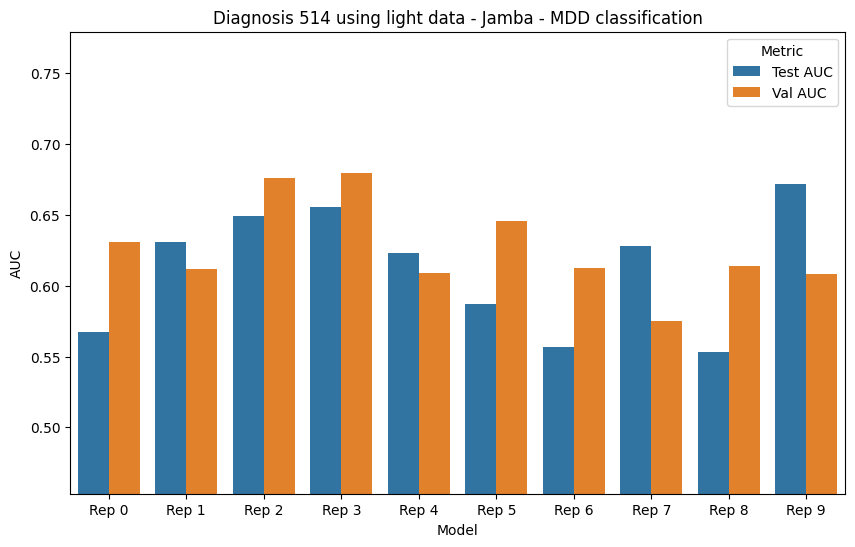

: 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Example data

def compare_metric_many_itr(test_metric, val_metric, metric_name, title_name):
    data = {
        'Name': [f'Rep {i}' for i in range(len(test_metric))],
        f'Test {metric_name}': test_metric,
        f'Val {metric_name}': val_metric
    }

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Melt the DataFrame to long-form for seaborn
    df_melted = df.melt(id_vars='Name', value_vars=['Test AUC', 'Val AUC'], var_name='Metric', value_name='AUC')

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_melted, x='Name', y='AUC', hue='Metric')
    plt.title('Comparison of Test AUC and Validation AUC')
    plt.ylabel('AUC')
    plt.xlabel('Model')
    plt.legend(title='Metric')
    plt.title(title_name)
    min_val = min(df_melted['AUC']) - 0.1
    max_val = max(df_melted['AUC']) + 0.1
    
    plt.ylim(min_val, max_val)  # Set y-axis limits for better visualization
    plt.show()

test_auc = np.array(all_test_metrics)[:, -1]
val_auc = np.array(all_val_metrics)[:, -1]
test_auc, val_auc
title_name = 'Diagnosis 514 using light data - Jamba - MDD classification'
compare_metric_many_itr(test_auc, val_auc, 'AUC', title_name)

In [15]:
# read the best acc and its corresponding epoch 
import pandas as pd 
def get_best_acc_epoch(csv_file):
    df = pd.read_csv(csv_file)
    index_of_best_acc = df['val_accuracy'].argmax()
    return index_of_best_acc
# csv_file = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/jamba/diagnosis514/skf_s2_conv1d_1000epochs_1e9lrmdd_classification_jamba/SKF_holdout/stratified_nested_10_CV_fold-9/history.csv'
# df = pd.read_csv(csv_file)
# index_of_best_acc = df['val_accuracy'].argmax()
# index_of_best_acc